# Optimizing only the centroid

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import shutil
from pathlib import Path

import aps
import aps.ai.autoalignment.beamline28IDB.optimization.common as opt_common
import aps.ai.autoalignment.beamline28IDB.optimization.movers as movers
import aps.ai.autoalignment.beamline28IDB.optimization.configs as configs
import IPython
import matplotlib.pyplot as plt
import numpy as np
import optuna
from aps.ai.autoalignment.beamline28IDB.optimization.optuna_botorch import OptunaOptimizer
from aps.ai.autoalignment.common.util import clean_up
from aps.ai.autoalignment.common.util.shadow.common import (
    get_shadow_beam_spatial_distribution,
    load_shadow_beam,
    plot_shadow_beam_spatial_distribution,
)
from tqdm import tqdm

%matplotlib inline

In [3]:
DEFAULT_RANDOM_SEED = np.random.randint(100000)
print(DEFAULT_RANDOM_SEED)

70610


In [4]:
root_dir = Path(aps.__path__[0]).parents[0]
base_dir = root_dir / 'work_directory'
orig_work_dir = base_dir /'28-ID'
temp_work_dir = base_dir / f'tmp_work_dir_28-ID-{DEFAULT_RANDOM_SEED}'
temp_work_dir.mkdir(exist_ok=True)

In [5]:
dat_files = list(orig_work_dir.glob('*.dat')) + list(orig_work_dir.glob('*.ini'))
for df in dat_files:
    shutil.copy(df, temp_work_dir)

In [6]:
os.chdir(temp_work_dir)

In [7]:
input_beam_path = "primary_optics_system_beam.dat"

In [8]:
move_motors_ranges = {
    "hb_pitch": [-0.05, 0.05],  # in mrad
    "vb_pitch": [-0.05, 0.05],
}

In [9]:
xrange, yrange = configs.X_RANGE, configs.Y_RANGE

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-70610/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-70610/Downstream_HKB_bender_profile.dat written to disk.


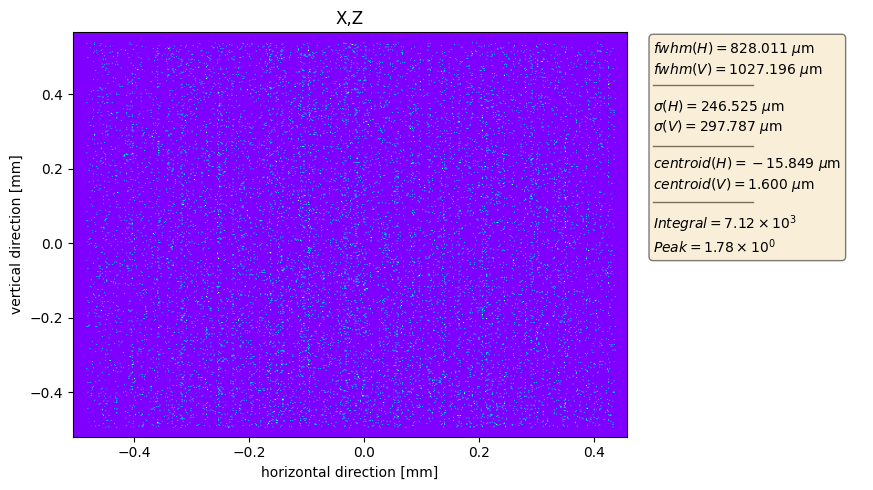

In [10]:
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path)
beam, hist, dw = opt_common.get_beam_hist_dw(focusing_system, random_seed=DEFAULT_RANDOM_SEED)

plot_shadow_beam_spatial_distribution(
    beam,
    nbins=501,
)

In [11]:
initial_absolute_positions = np.array(movers.get_absolute_positions(focusing_system, list(move_motors_ranges.keys())))
print(initial_absolute_positions)

[3. 3.]


In [12]:
centroid_ground, *_ = opt_common.get_centroid_distance(
    photon_beam=beam,
    xrange=configs.X_RANGE,
    yrange=configs.Y_RANGE,
    nbins=501,
    random_seed=DEFAULT_RANDOM_SEED,
)
centroid_ground

0.015923155588438848

Random initialization is ['hb_pitch', 'vb_pitch'] [-0.03710238045608494, 0.026517053713210156]


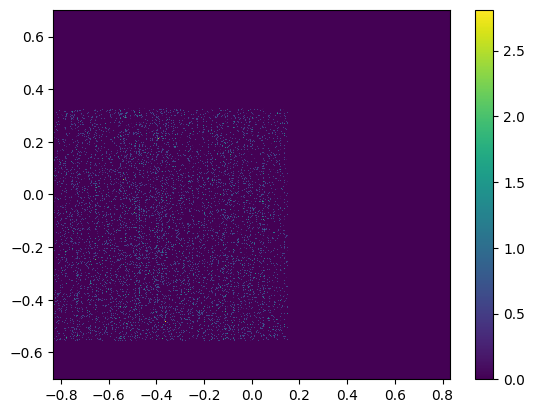

In [13]:
initial_movement, focusing_system, (beam, hist, dw) = opt_common.get_random_init(
    focusing_system,
    motor_types_and_ranges=move_motors_ranges,
    xrange=xrange,
    yrange=yrange,
    intensity_sum_threshold=6e3,
    nbins=501,
    random_seed=DEFAULT_RANDOM_SEED,
)
plt.pcolormesh(hist.vv, hist.hh, hist.data_2D.T)
plt.colorbar()
plt.show()

In [14]:
hist.data_2D.sum()

6759.082171546534

In [28]:
focusing_system = movers.move_motors(focusing_system, list(move_motors_ranges.keys()), initial_absolute_positions + initial_movement, movement='absolute')

0.3539077496245351 0.38732465124448423


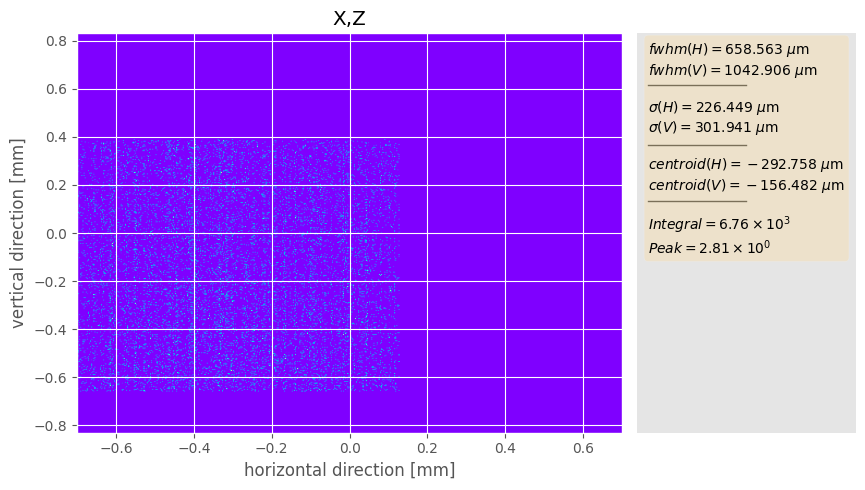

In [29]:
beam = opt_common.get_beam(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
centroid, *_ = opt_common.get_centroid_distance(photon_beam=beam, random_seed=DEFAULT_RANDOM_SEED)
sigma, *_ = opt_common.get_sigma(photon_beam=beam)
print(centroid, sigma)


plot_shadow_beam_spatial_distribution(
    beam,
    xrange=xrange,
    yrange=yrange,
    nbins=501,
)

In [30]:
opt_trial = OptunaOptimizer(
    focusing_system,
    motor_types=list(move_motors_ranges.keys()),
    random_seed=DEFAULT_RANDOM_SEED,
    loss_parameters=["centroid"],
    use_gaussian_fit=False,
    multi_objective_optimization=False,
    camera_xrange=xrange,
    camera_yrange=yrange,
    camera_nbins=501,
)

In [31]:
constraints = {"sum_intensity": 7.1e3}
opt_trial.set_optimizer_options(
    motor_ranges=list(move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=6e3,
    constraints=constraints,
    acquisition_function="qnei",
    botorch_model_mean_module=mean_module,
    botorch_model_covar_module=covar_module,
    n_startup_trials=5
)

[I 2022-11-09 00:45:31,910] A new study created in memory with name: no-name-abd0805b-615a-4b33-93cd-59a2928776d9


In [32]:
opt_trial.trials(20)

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/trial/_trial.py:618: UserWarning: Fixed parameter 'hb_pitch' with value 0.0 is out of range for distribution FloatDistribution(high=0.04975, log=False, low=-0.05, step=0.00175).
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/trial/_trial.py:618: UserWarning: Fixed parameter 'vb_pitch' with value 0.0 is out of range for distribution FloatDistribution(high=0.04975, log=False, low=-0.05, step=0.00175).
  warnings.warn(
[I 2022-11-09 00:45:37,613] Trial 0 finished with value: 0.3319550024446338 and parameters: {'hb_pitch': 0.0, 'vb_pitch': 0.0}. Best is trial 0 with value: 0.3319550024446338.
[I 2022-11-09 00:45:37,730] Trial 1 finished with value: 0.26947286621383143 and parameters: {'hb_pitch': 0.009500000000000001, 'vb_pitch': -0.006249999999999999}. Best is trial 1 with value: 0.2694728662138314

0.3319550024446338
0.26947286621383143


[I 2022-11-09 00:45:37,851] Trial 2 finished with value: 0.35922017412036167 and parameters: {'hb_pitch': 0.0007500000000000007, 'vb_pitch': 0.009500000000000001}. Best is trial 1 with value: 0.26947286621383143.
[I 2022-11-09 00:45:37,973] Trial 3 finished with value: 0.27100080075248134 and parameters: {'hb_pitch': 0.009500000000000001, 'vb_pitch': -0.044750000000000005}. Best is trial 1 with value: 0.26947286621383143.


0.35922017412036167
0.27100080075248134


[I 2022-11-09 00:45:38,095] Trial 4 finished with value: 0.2860323641542435 and parameters: {'hb_pitch': 0.0024999999999999953, 'vb_pitch': -0.02025}. Best is trial 1 with value: 0.26947286621383143.


0.2860323641542435


[I 2022-11-09 00:45:39,194] Trial 5 pruned. 


0.5129930809892708


[I 2022-11-09 00:45:39,993] Trial 6 finished with value: 0.35631117695636727 and parameters: {'hb_pitch': -0.011500000000000003, 'vb_pitch': -0.01675}. Best is trial 1 with value: 0.26947286621383143.


0.35631117695636727


[I 2022-11-09 00:45:40,903] Trial 7 pruned. 


0.517012779548538


[I 2022-11-09 00:45:41,682] Trial 8 finished with value: 0.10828532870848961 and parameters: {'hb_pitch': 0.04625, 'vb_pitch': -0.009750000000000002}. Best is trial 8 with value: 0.10828532870848961.


0.10828532870848961


[I 2022-11-09 00:45:42,811] Trial 9 finished with value: 0.17110780146007393 and parameters: {'hb_pitch': 0.04975, 'vb_pitch': -0.05}. Best is trial 8 with value: 0.10828532870848961.


0.17110780146007393


[I 2022-11-09 00:45:43,892] Trial 10 finished with value: 0.33721651763423327 and parameters: {'hb_pitch': 0.04975, 'vb_pitch': 0.0305}. Best is trial 8 with value: 0.10828532870848961.


0.33721651763423327


[I 2022-11-09 00:45:44,729] Trial 11 pruned. 


0.4341000920157017


[I 2022-11-09 00:45:45,556] Trial 12 pruned. 


0.49419200849079137


[I 2022-11-09 00:45:46,447] Trial 13 finished with value: 0.043714008662798114 and parameters: {'hb_pitch': 0.0445, 'vb_pitch': -0.027250000000000003}. Best is trial 13 with value: 0.043714008662798114.


0.043714008662798114


[I 2022-11-09 00:45:47,419] Trial 14 pruned. 


0.6364852761161405


[I 2022-11-09 00:45:48,328] Trial 15 pruned. 


0.6364852761161405


[I 2022-11-09 00:45:49,270] Trial 16 finished with value: 0.08537165062238819 and parameters: {'hb_pitch': 0.04975, 'vb_pitch': -0.025500000000000002}. Best is trial 13 with value: 0.043714008662798114.


0.08537165062238819


[I 2022-11-09 00:45:50,804] Trial 17 finished with value: 0.04621092910732976 and parameters: {'hb_pitch': 0.034, 'vb_pitch': -0.027250000000000003}. Best is trial 13 with value: 0.043714008662798114.


0.04621092910732976


[I 2022-11-09 00:45:51,648] Trial 18 finished with value: 0.2193844973856439 and parameters: {'hb_pitch': 0.023499999999999993, 'vb_pitch': 0.004249999999999997}. Best is trial 13 with value: 0.043714008662798114.


0.2193844973856439


[I 2022-11-09 00:45:52,830] Trial 19 finished with value: 0.3735832016825551 and parameters: {'hb_pitch': 0.0445, 'vb_pitch': 0.048}. Best is trial 13 with value: 0.043714008662798114.


0.3735832016825551


In [20]:
from copy import deepcopy
mean_module = deepcopy(opt_trial.study.sampler._model.mean_module)
covar_module = deepcopy(opt_trial.study.sampler._model.covar_module)

In [21]:
opt_trial.study.best_trials

[FrozenTrial(number=90, values=[0.022548418675591358], datetime_start=datetime.datetime(2022, 11, 9, 0, 34, 32, 679714), datetime_complete=datetime.datetime(2022, 11, 9, 0, 34, 36, 396915), params={'hb_pitch': 0.03924999999999999, 'vb_pitch': -0.029}, distributions={'hb_pitch': FloatDistribution(high=0.04975, log=False, low=-0.05, step=0.00175), 'vb_pitch': FloatDistribution(high=0.04975, log=False, low=-0.05, step=0.00175)}, user_attrs={'sum_intensity_constraint': -1, 'wsum': 2397.0842212155735}, system_attrs={'constraints': (-1,)}, intermediate_values={}, trial_id=90, state=TrialState.COMPLETE, value=None)]

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_24417/1243347140.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(opt_trial.study)


<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

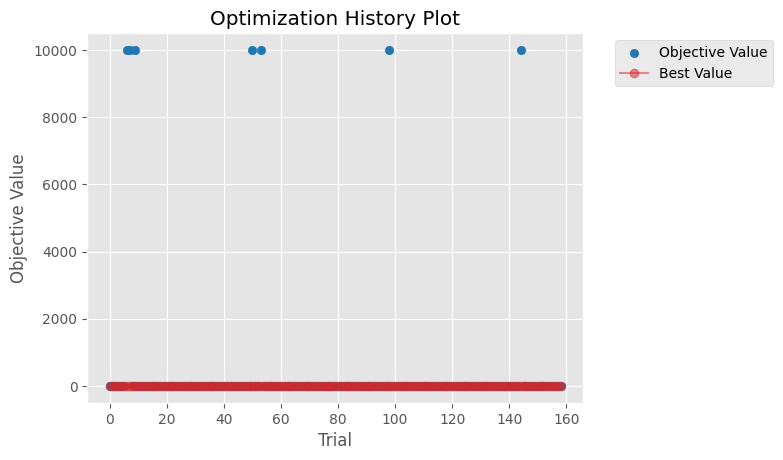

In [22]:
optuna.visualization.matplotlib.plot_optimization_history(opt_trial.study)

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_24417/1243347140.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(opt_trial.study)


<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

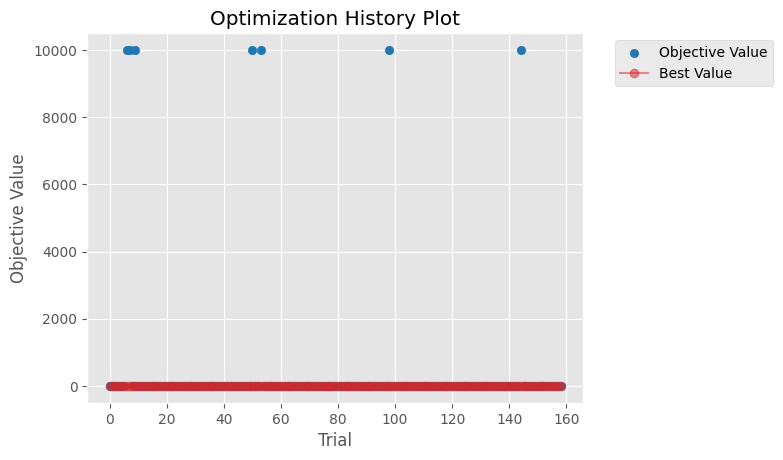

In [23]:
optuna.visualization.matplotlib.plot_optimization_history(opt_trial.study)

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_24417/1592859794.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(opt_trial.study)


<AxesSubplot:title={'center':'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

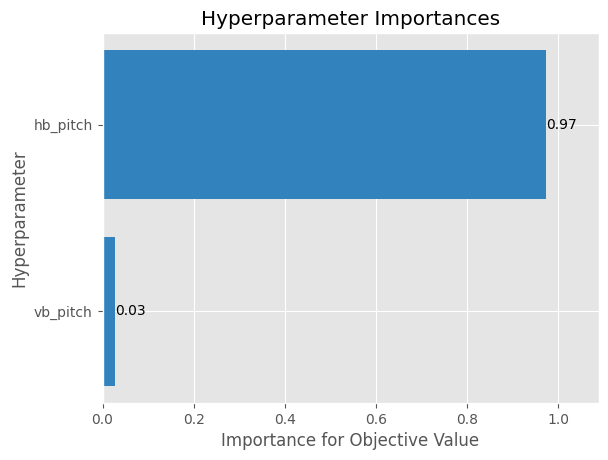

In [24]:
optuna.visualization.matplotlib.plot_param_importances(opt_trial.study)

In [25]:
opt_trial.study.best_params, opt_trial.study.best_value

({'hb_pitch': 0.03924999999999999, 'vb_pitch': -0.029}, 0.022548418675591358)

In [26]:
opt_trial.study.best_params

{'hb_pitch': 0.03924999999999999, 'vb_pitch': -0.029}

0.022548418675591358


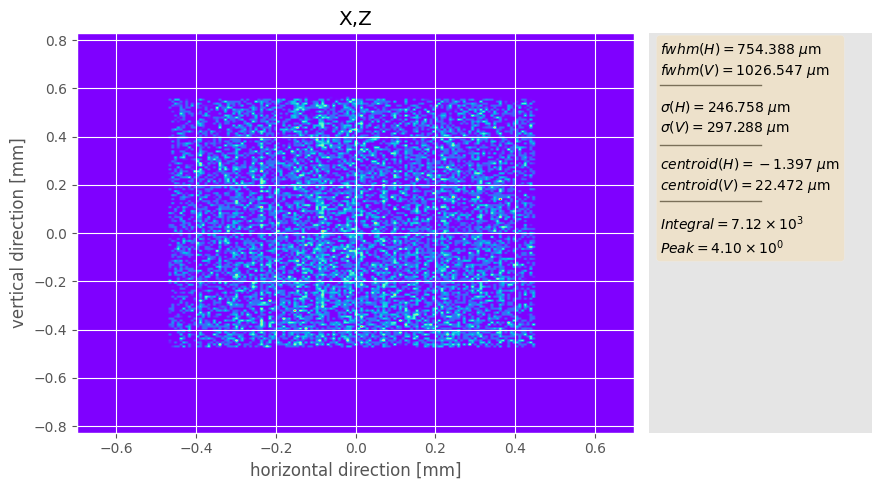

In [27]:
params = opt_trial.study.best_params
vals = opt_trial.study.best_value
current_params = []
for mot in opt_trial.motor_types:
    current_params.append(params[mot])
print(opt_trial._loss_fn_this(current_params))
plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=xrange, yrange=yrange)#opt_trial._camera_xrange, yrange=opt_trial._camera_yrange, )

In [302]:
opt_trial._base_sampler._search_space

In [168]:
opt_trial.initial_motor_positions, opt_trial.study.trials[7].params

([2.9528761101962036, 2.9581120979521867],
 {'hb_pitch': 0.048, 'vb_pitch': 0.040999999999999995})

In [171]:
list(move_motors_ranges.keys())

['hb_pitch', 'vb_pitch']

In [210]:
focusing_system = movers.move_motors(focusing_system, list(move_motors_ranges.keys()), 
                                     initial_absolute_positions + initial_movement + np.array([0.048, 0.041]), 
                                     movement='absolute')

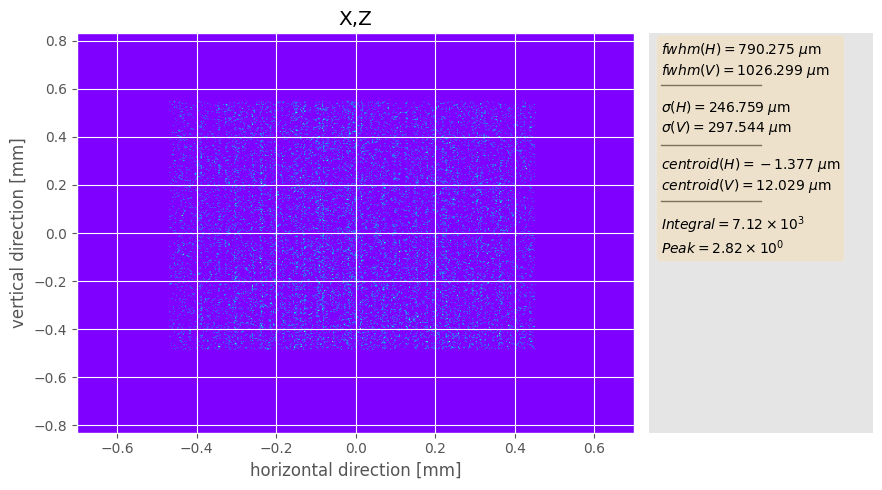

In [211]:
beam = opt_common.get_beam(focusing_system, random_seed=DEFAULT_RANDOM_SEED)

plot_shadow_beam_spatial_distribution(
    beam,
    xrange=xrange,
    yrange=yrange,
    nbins=501,
)

In [203]:
initial_absolute_positions

array([3., 3.])

In [205]:
movers.get_absolute_positions(focusing_system, ['hb_pitch', 'vb_pitch'])

[3.0471238898038977, 3.0418879020479146]

In [206]:
initial_movement

[-0.04711502947696457, -0.04219930091612371]